Libraries Used

In [258]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [259]:
import numpy as np
import scipy
import pandas as pd
import datetime
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import imageio



Helper Functions:

In [260]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

In [261]:
def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date


In [262]:
StationMetaData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')
StationMetaData

,station,latitude,longitude,elevation_m,is_greenland
0,NGFJ,80.568475,-16.841131,35.5,True
1,JWLF,83.111656,-45.119847,112.9,True
2,THU4,76.537106,-68.824953,36.2,True
3,JGBL,82.208758,-31.004208,753.3,True
4,THU2,76.537047,-68.825050,36.2,True
...,...,...,...,...,...
71,MIK2,68.140281,-31.451825,815.9,True
72,KUAQ,68.587000,-33.052750,865.2,True
73,KSUT,64.070697,-52.007697,40.7,True
74,RINK,71.848500,-50.993967,1337.9,True


In [240]:
## LTM Creation
from datetime import timedelta

stations_names_with_data = []
metadata_records = []

MAX_GAP_DAYS = 14  # maximum acceptable gap (in days)

def find_longest_continuous_segment(dates, max_gap_days=14):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 5:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]
        
        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)

        # Compute monthly climatology
        df['month_day'] = df.index.map(lambda x: x.strftime('%m-%d'))
        df = df[df['month_day'] != '02-29']
        climatology_daily = df.groupby('month_day')[['east', 'north', 'up']].mean()
    
        climatology_daily.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station_name + '_DailyLTM.csv', index = True) 
        
        start_date = continuous_segment[0]
        end_date = continuous_segment[-1]
        duration_years = round((end_date - start_date).days / 365.25, 2)

        metadata_records.append({
            'station': station_name,
            'start_date': start_date.strftime('%Y-%m-%d'),
            'end_date': end_date.strftime('%Y-%m-%d'),
            'years_of_data': duration_years
        })

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

#metadata_df = pd.DataFrame(metadata_records)
#metadata_df.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/LTM_station_metadata.csv', index=False)

  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping ISOR: continuous segment too short.
  → Skipping TIMM: continuous segment too short.
  → Skipping KLY2: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping KULU: continuous segment too short.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping KAPI: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT.

In [502]:
## LTM Creation
from datetime import timedelta

stations_names_with_data = []
metadata_records = []

MAX_GAP_DAYS = 14  # maximum acceptable gap (in days)

wdays = 30

def find_longest_continuous_segment(dates, max_gap_days=14):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 3:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]
        
        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)

        df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays).mean()

        # Drop rows with NaNs resulting from the rolling average
        df_rolling = df_rolling.dropna()

        # Compute monthly climatology (LTM)
        df_rolling['month_day'] = df_rolling.index.map(lambda x: x.strftime('%m-%d'))
        df_rolling = df_rolling[df_rolling['month_day'] != '02-29']
        climatology_daily = df_rolling.groupby('month_day')[['east', 'north', 'up']].mean()
        stds = df_rolling.groupby('month_day')[['east', 'north', 'up']].std()
        stds.columns = ['east_sd', 'north_sd', 'up_sd']
        climatology_daily = climatology_daily.join(stds)

        climatology_daily.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station_name + '_Daily' + str(wdays) + 'RollingLTM.csv', index = True)  
        stations_names_with_data.append(station_name)
    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

#metadata_df = pd.DataFrame(metadata_records)
#metadata_df.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/LTM_station_metadata.csv', index=False)

  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT. Skipping.


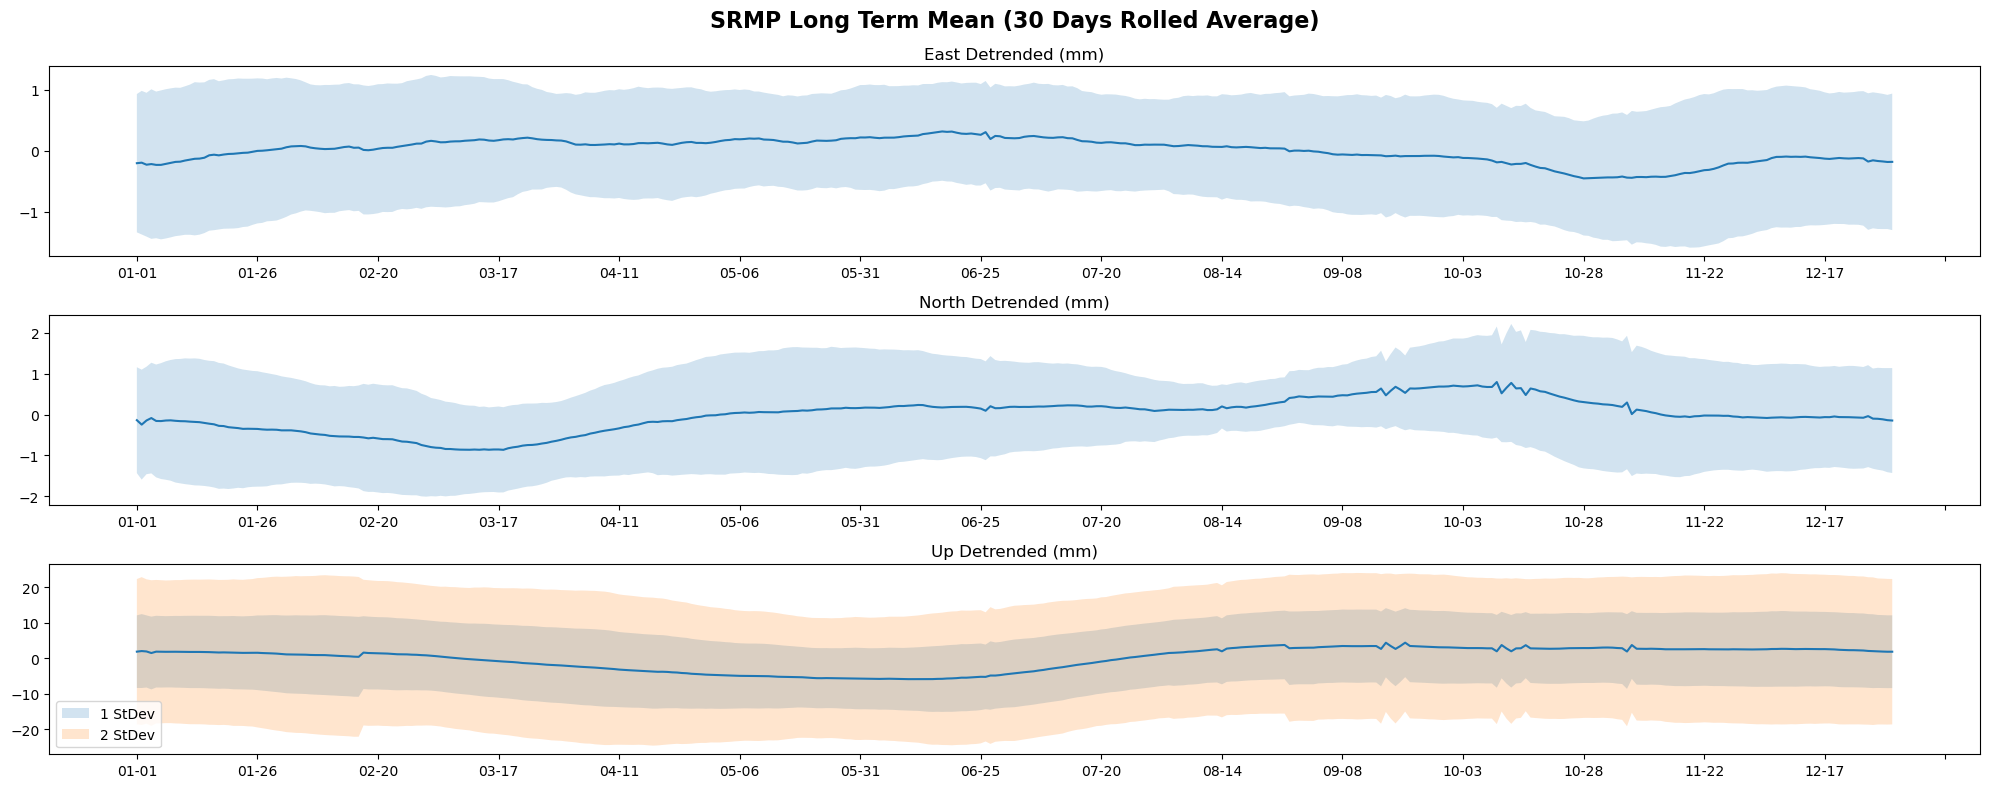

In [505]:
station = 'SRMP'
climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily30RollingLTM.csv')

fig, axs = plt.subplots(3, 1, figsize=(20, 8))
Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#month_ticks = [f'{month:02d}-01' for month in range(1, 13)]

axs[0].plot(climatology_daily['month_day'],climatology_daily['east'])
axs[0].fill_between(climatology_daily['month_day'], climatology_daily['east'] - climatology_daily['east_sd'], climatology_daily['east'] + climatology_daily['east_sd'], alpha=0.2)

axs[1].plot(climatology_daily.index,climatology_daily['north'])
axs[1].fill_between(climatology_daily['month_day'], climatology_daily['north'] - climatology_daily['north_sd'], climatology_daily['north'] + climatology_daily['north_sd'], alpha=0.2)

axs[2].plot(climatology_daily.index,climatology_daily['up'])
axs[2].fill_between(climatology_daily['month_day'], climatology_daily['up'] - climatology_daily['up_sd'], climatology_daily['up'] + climatology_daily['up_sd'], alpha=0.2, label = '1 StDev')
axs[2].fill_between(climatology_daily['month_day'], climatology_daily['up'] - climatology_daily['up_sd'] * 2, climatology_daily['up'] + climatology_daily['up_sd'] * 2, alpha=0.2, label = '2 StDev')

for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    #ax.set_xticklabels(Time_months, rotation=45)
    
axs[0].set_title('East Detrended (mm)', size = 12)
axs[1].set_title('North Detrended (mm)', size = 12)
axs[2].set_title('Up Detrended (mm)', size = 12)

axs[2].legend()

fig.suptitle(station + ' Long Term Mean (30 Days Rolled Average)', weight= 'bold', size = 16, y = 0.98, x = 0.51)
plt.tight_layout()
plt.show()

## Animation of Vectors

In [244]:
Time_days =  pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_DailyLTM.csv').month_day

cmap = cm.coolwarm_r
vmin = -8  # or use np.nanmin of all station 'up' values if precomputed
vmax = 8   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month_day in enumerate(Time_days):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Daily Average Station Displacement Vectors  " + str(month_day))

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_DailyLTM.csv')
        
        smdt = StationMetaData.loc[StationMetaData['station'] == station]

        lon = smdt.longitude
        lat = smdt.latitude

        ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
        
        U = np.array([climatology_daily['east'].iloc[n]])
        V = np.array([climatology_daily['north'].iloc[n]])
        C = np.array(climatology_daily['up'].iloc[n]) 

        scale_factor = 12

        ax.quiver(
            lon, lat, U , V ,
            [C],  # color mapped by vertical component
            scale=scale_factor,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            width=0.005,
            alpha=1,
            edgecolor='k',
            linewidth=0.5,
            headwidth=2,         # smaller width
            headlength=2,        # smaller length
            headaxislength=2.5
        )
        magnitude = np.sqrt(U**2 + V**2)
        #print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month_day}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily.mp4' , fps=12) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 1100) to (800, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Rolling Average

In [278]:
Time_days =  pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_DailyLTM.csv').month_day

cmap = cm.coolwarm_r
vmin = -7  # or use np.nanmin of all station 'up' values if precomputed
vmax = 7   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month_day in enumerate(Time_days):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Daily Average (15 Days Rolled Average) Displacement " + str(month_day))

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily15RollingLTM.csv')
        smdt = StationMetaData.loc[StationMetaData['station'] == station]

        lon = smdt.longitude
        lat = smdt.latitude

        ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
        
        U = np.array([climatology_daily['east'].iloc[n]])
        V = np.array([climatology_daily['north'].iloc[n]])
        C = np.array(climatology_daily['up'].iloc[n]) 

        scale_factor = 12

        ax.quiver(
            lon, lat, U , V ,
            [C],  # color mapped by vertical component
            scale=scale_factor,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            width=0.005,
            alpha=1,
            edgecolor='k',
            linewidth=0.5,
            headwidth=2,         # smaller width
            headlength=2,        # smaller length
            headaxislength=2.5
        )
        magnitude = np.sqrt(U**2 + V**2)
        #print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month_day}_15Rolling.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily15Rolling.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily15Rolling.mp4' , fps=12) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 1100) to (800, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Overplotting Every Year for a Station

In [512]:
station_name = 'SRMP'

raw_data = get_data(station_name)
time = raw_data[:, 0]
converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
data = raw_data[:, 1:4]
error = raw_data[:, 4:]

# Detrend data
data_detrended = scipy.signal.detrend(data, axis=0)

# Build DataFrame
df = pd.DataFrame({'time': converted_dates})
df['east'] = data_detrended[:, 0]
df['north'] = data_detrended[:, 1]
df['up'] = data_detrended[:, 2]
df.set_index('time', inplace=True)

df_rolling = df.rolling(window=30, center=True, min_periods=30).mean()
df_rolling['year'] = df_rolling.index.map(lambda x: x.strftime('%y'))
df_rolling.index = pd.to_datetime(df_rolling.index)
df_rolling['doy'] = df_rolling.index.dayofyear
df_rolling

,east,north,up,year,doy
time,,,,,
2007-08-13,NaN,NaN,NaN,07,225
2007-08-14,NaN,NaN,NaN,07,226
2007-08-15,NaN,NaN,NaN,07,227
2007-08-16,NaN,NaN,NaN,07,228
2007-08-17,NaN,NaN,NaN,07,229
...,...,...,...,...,...
2025-02-26,NaN,NaN,NaN,25,57
2025-02-27,NaN,NaN,NaN,25,58
2025-02-28,NaN,NaN,NaN,25,59


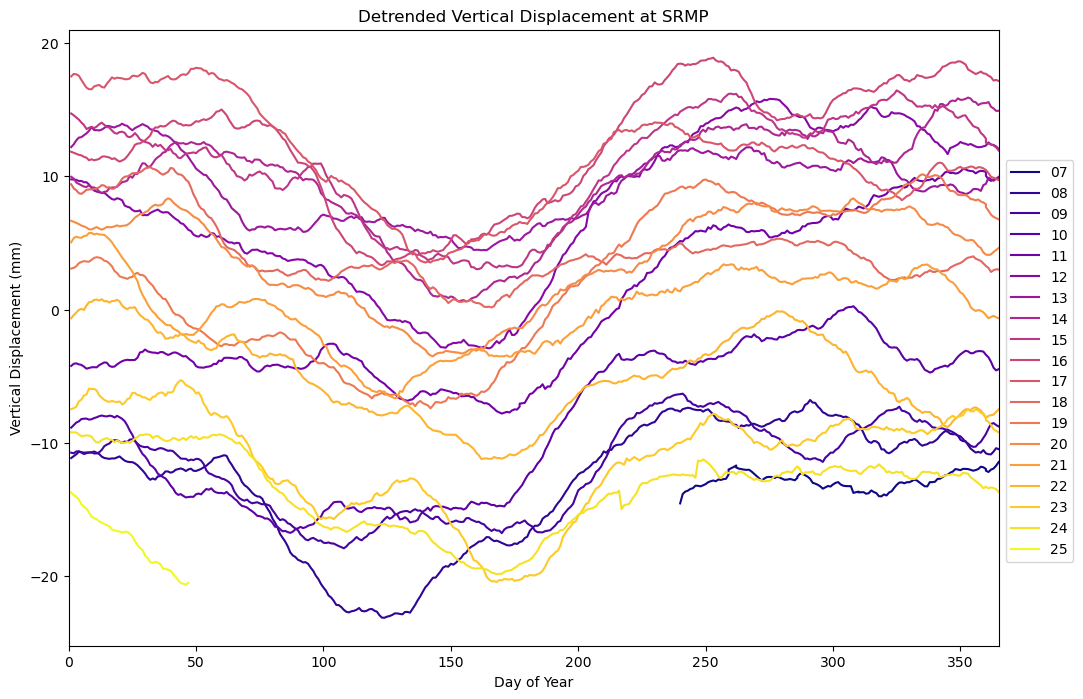

In [526]:
fig= plt.figure(figsize=(12,8))

col = cm.get_cmap('plasma', len(np.unique(df_rolling.year)))

peak = []
minima = []
amplitude = []
filenames = []

plt.xlabel('Day of Year')
plt.ylabel('Vertical Displacement (mm)')
plt.title('Detrended Vertical Displacement at ' + station_name)
plt.xlim(0,365)


for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        a = data['up'].idxmin()
        minima.append(data['doy'][a])

        b = data['up'].idxmax()
        peak.append(data['doy'][b])

        a1 = data['up'].min()
        b1 = data['up'].max()
        amplitude.append(b1-a1)

    plt.plot(data['doy'], data['up'], label = year, color = col(i), lw = 1.5)
    plt.legend(bbox_to_anchor=(1, 0.8))
    filename = ('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/DetVerDisp_' + station_name + '_' + str(year) + '.png')
    plt.savefig(filename)
    filenames.append(filename)
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/DetVerDisp_' + station_name + '.gif', mode='I', duration=500.0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

peak = np.array(peak)
minima = np.array(minima)
amplitude = np.array(amplitude)

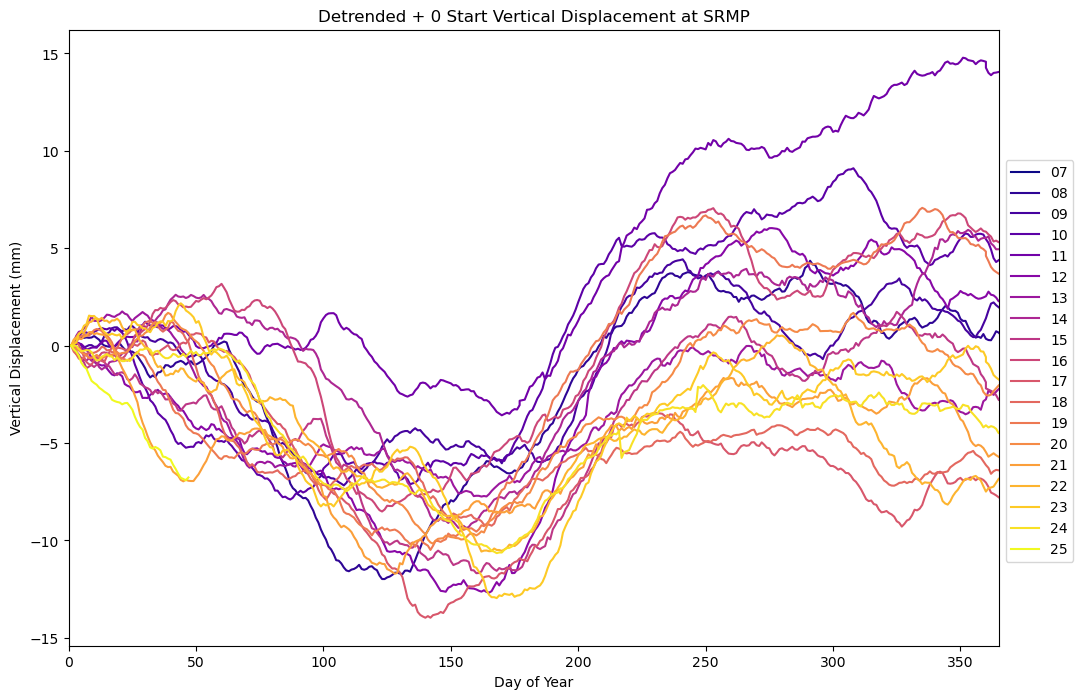

In [525]:
fig= plt.figure(figsize=(12,8))

col = cm.get_cmap('plasma', len(np.unique(df_rolling.year)))

peak = []
minima = []
amplitude = []
filenames = []

plt.xlabel('Day of Year')
plt.ylabel('Vertical Displacement (mm)')
plt.title('Detrended + 0 Start Vertical Displacement at ' + station_name)
plt.xlim(0,365)


for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        a = data['up'].idxmin()
        minima.append(data['doy'][a])

        b = data['up'].idxmax()
        peak.append(data['doy'][b])

        a1 = data['up'].min()
        b1 = data['up'].max()
        amplitude.append(b1-a1)

    plt.plot(data['doy'], data['up'] - data['up'][0], label = year, color = col(i), lw = 1.5)
    plt.legend(bbox_to_anchor=(1, 0.8))
    filename = ('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0VerDisp_' + station_name + '_' + str(year) + '.png')
    plt.savefig(filename)
    filenames.append(filename)
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Det0VerDisp_' + station_name + '.gif', mode='I', duration=500.0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

peak = np.array(peak)
minima = np.array(minima)
amplitude = np.array(amplitude)

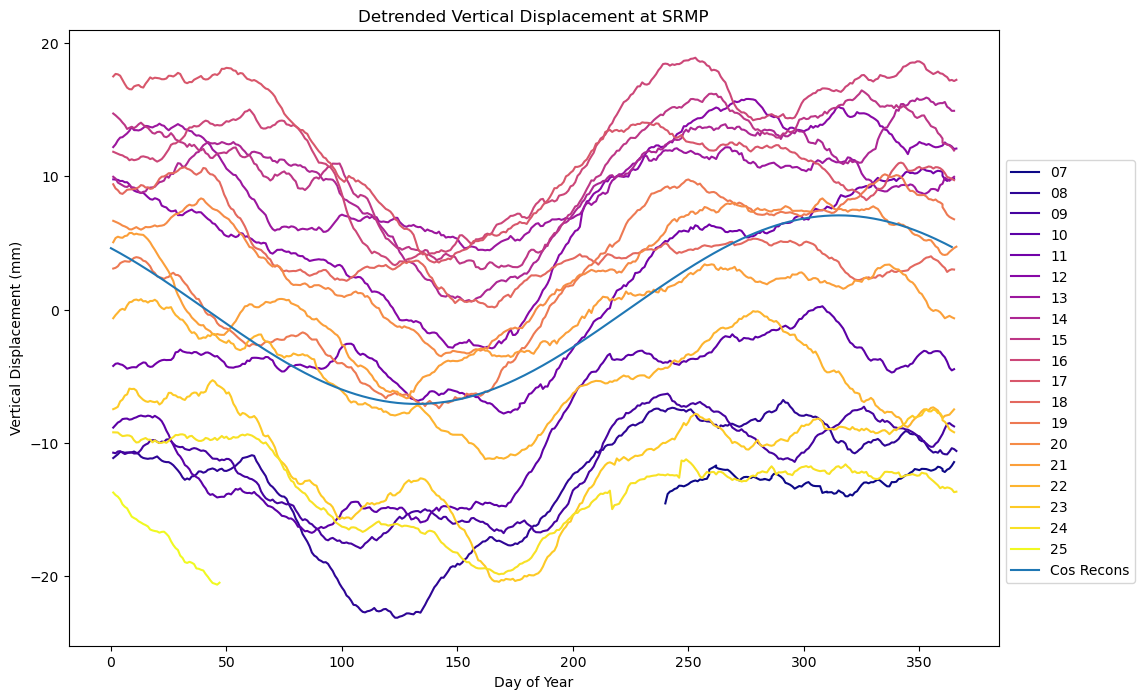

In [516]:
fig= plt.figure(figsize=(12,8))

col = cm.get_cmap('plasma', len(np.unique(df_rolling.year)))

peak = []
minima = []
amplitude = []

for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        a = data['up'].idxmin()
        minima.append(data['doy'][a])

        b = data['up'].idxmax()
        peak.append(data['doy'][b])

        a1 = data['up'].min()
        b1 = data['up'].max()
        amplitude.append(b1-a1)

    plt.plot(data['doy'], data['up'], label = year, color = col(i))

amplitude = np.array(amplitude)
meanamp = np.mean(amplitude)
peak = np.array(peak)
minima= np.array(minima)

x = np.arange(365)
y = (meanamp / 2) * np.cos( np.pi / (365/2) * ( x + 50)) 
#ynoise = (meanamp  / 2) * np.cos( np.pi / (365/2) * ( x + 50 +  3 * np.random.rand(365)))   + 1 * np.random.rand(365) *  np.random.rand(365)
plt.plot(x,y, label = 'Cos Recons')
#plt.plot(x,ynoise, label = 'Cos + Noise')
plt.xlabel('Day of Year')
plt.ylabel('Vertical Displacement (mm)')
plt.title('Detrended Vertical Displacement at ' + station_name)
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show()

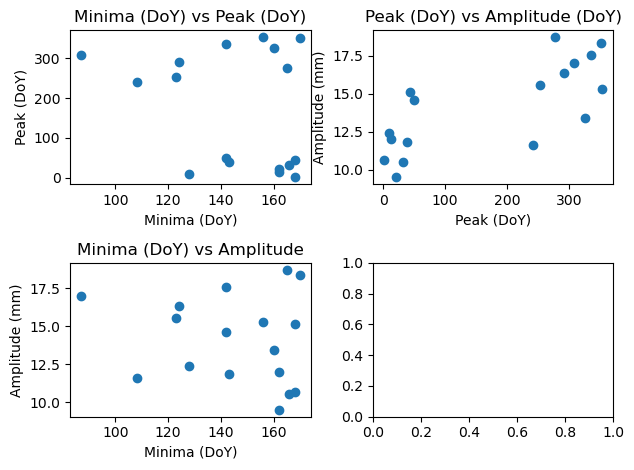

In [463]:
fig, axs = plt.subplots(2, 2)

axs[0,0].scatter(minima,peak)
axs[0,0].set_title('Minima (DoY) vs Peak (DoY)')
axs[0,0].set_xlabel('Minima (DoY)')
axs[0,0].set_ylabel('Peak (DoY)')

axs[1,0].scatter(minima,amplitude)
axs[1,0].set_title('Minima (DoY) vs Amplitude')
axs[1,0].set_ylabel('Amplitude (mm)')
axs[1,0].set_xlabel('Minima (DoY)')

axs[0,1].scatter(peak,amplitude)
axs[0,1].set_title('Peak (DoY) vs Amplitude (DoY)')
axs[0,1].set_ylabel('Amplitude (mm)')
axs[0,1].set_xlabel('Peak (DoY)')

fig.tight_layout()